In [79]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from types import SimpleNamespace

import pySPEC as ps
from pySPEC.time_marching import SWHD_1D, Adjoint_SWHD_1D

param_path = '/home/lpancotto/code/tesis/adjoint/pySPEC/examples/adjoint_lbfgs4'
# param_path = '/home/lpancotto/code/tesis/adjoint/pySPEC/examples/adjoint_sgd_SimpleGauss'

# Parse JSON into an object with attributes corresponding to dict keys.
fpm = json.load(open(f'{param_path}/params.json', 'r'), object_hook=lambda d: SimpleNamespace(**d))
fpm.Lx = 2*np.pi*fpm.Lx
fpm.out_path = fpm.forward_out_path
fpm.ostep = fpm.forward_ostep
# Parse JSON into an object with attributes corresponding to dict keys.
bpm = json.load(open(f'{param_path}/params.json', 'r'), object_hook=lambda d: SimpleNamespace(**d))
bpm.Lx = 2*np.pi*bpm.Lx
bpm.out_path = bpm.backward_out_path
bpm.ostep = bpm.backward_ostep
grid   = ps.Grid1D(fpm)
xx = grid.xx

In [80]:
Nt = round(fpm.T/fpm.dt)
h_uxs =   np.load(f'{bpm.out_path}/h_ux_memmap.npy', mmap_mode='r') # all uu fields in time
hx_uus =  np.load(f'{bpm.out_path}/hx_uu_memmap.npy', mmap_mode='r')  # all t hx_uu
uus =  np.load(f'{fpm.out_path}/uu_memmap.npy', mmap_mode='r')  # all t hx_uu


In [81]:
hx_uus.max(axis=0).shape

(1024,)

In [82]:
def get_dg_stats(h_uxs):
    # h_ux mean and max
    mh_uxs = h_uxs.mean(axis = 1)
    Mh_uxs = h_uxs.max(axis = 1)
    # argmaxh_ux =  np.argmax(np.array(mh_uxs))
    # maxh_ux =  np.array(mh_uxs).max()
    # integrate h_ux in time
    Th_uxs = np.trapz(h_uxs, dx = 1e-4, axis = 0) # -dt because integration is from T to t=0
    print('check shape of integral h_ux :  ' , Th_uxs.shape)
    # integrate h_ux in time and space
    XTh_uxs = np.trapz(Th_uxs ,  dx = 2*np.pi/len(Th_uxs))
    print('integral in space-time h_ux = ', XTh_uxs)
    return mh_uxs, Mh_uxs, Th_uxs, XTh_uxs

In [83]:
mhx_uus,  Mhx_uus , Thx_uus, XThx_uus = get_dg_stats(hx_uus)

tts = [tt for tt in range(len(h_uxs))]

# get uu for argmaxh_ux
argmaxh_ux =  np.argmax(np.array(Mhx_uus))
maxh_ux =  np.array(Mhx_uus).max()
# load
hh_max = np.load(f'{fpm.data_path}/hh_memmap.npy')[argmaxh_ux]
hb = np.load(f'{fpm.data_path}/hb.npy')


check shape of integral h_ux :   (1024,)
integral in space-time h_ux =  -0.000948645780680438


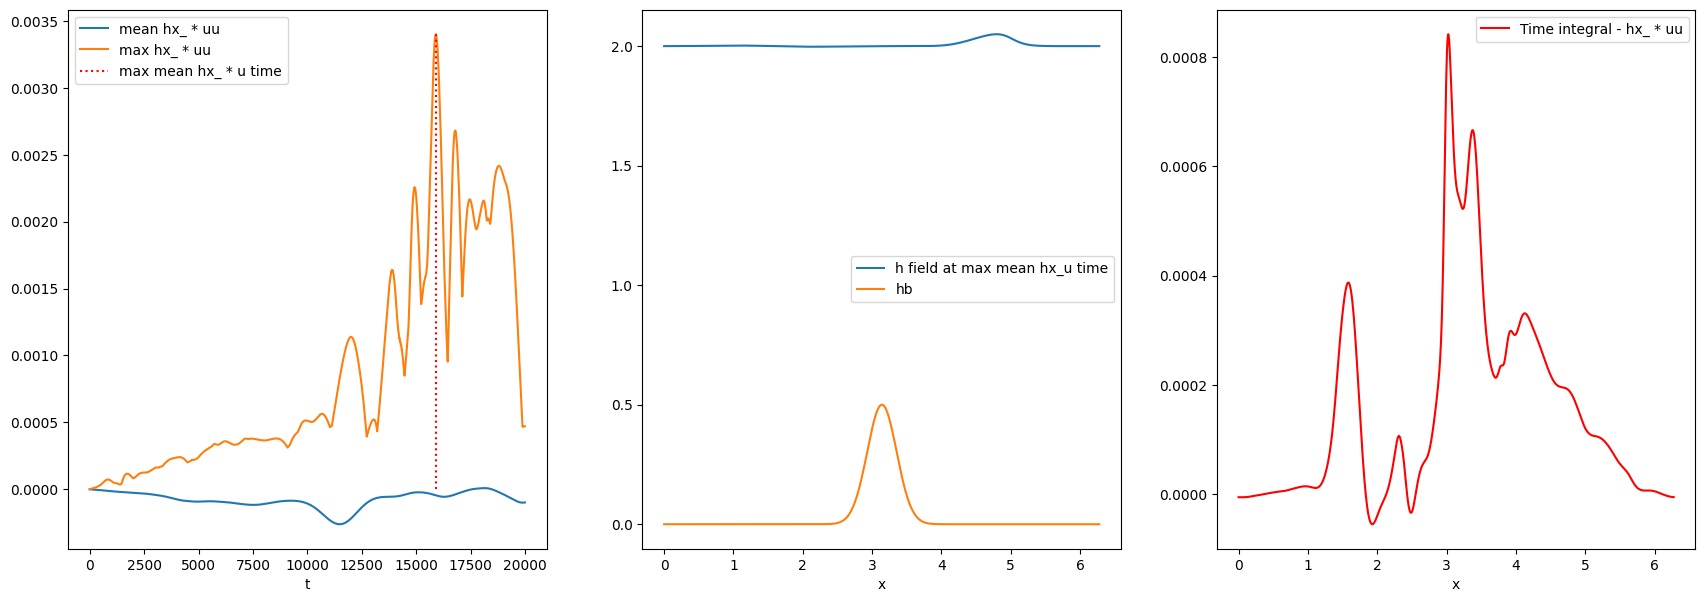

In [84]:
f,axs = plt.subplots(ncols=3 , figsize = (21,7))

axs[0].plot(tts , mhx_uus , label = 'mean hx_ * uu' )
axs[0].plot(tts , Mhx_uus , label = 'max hx_ * uu' )
axs[0].vlines(argmaxh_ux , 0 , maxh_ux, linestyles='dotted', color = 'red', label = 'max mean hx_ * u time')
axs[0].set_xlabel('t')
axs[0].legend()

axs[1].plot(xx , hh_max, label = 'h field at max mean hx_u time')
axs[1].plot(xx , hb, label = 'hb')
axs[1].set_xlabel('x')
axs[1].legend()

axs[2].plot(xx, - Thx_uus , alpha = 1, color = 'red' , label = 'Time integral - hx_ * uu')
axs[2].set_xlabel('x')
axs[2].legend()


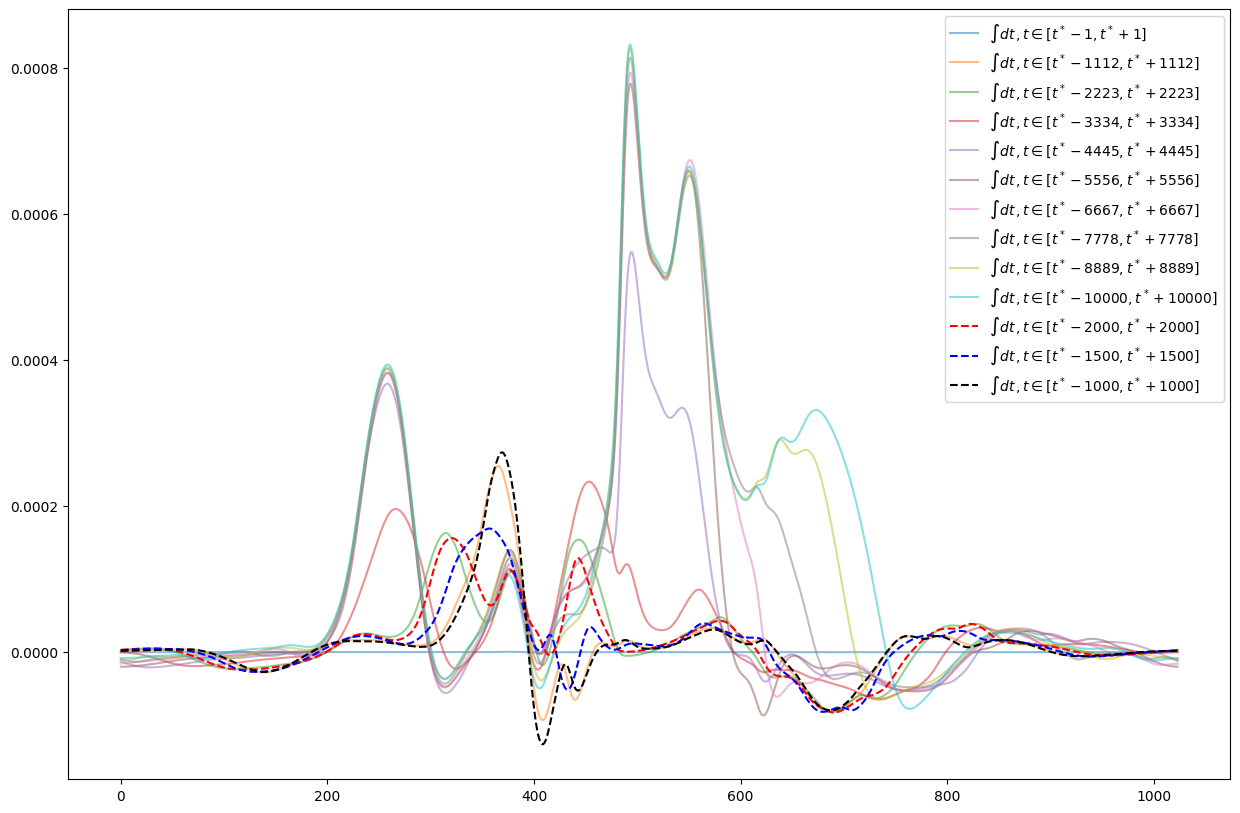

In [85]:
f,axs = plt.subplots(ncols=1 , figsize = (15,10))

for d in np.linspace(3,20000+1 , 10):
    axs.plot(- np.trapz(hx_uus[argmaxh_ux-int(d/2):argmaxh_ux+int(d/2)], dx = 1e-4, axis = 0) ,alpha = 0.5, label = f'$\int dt \, , t \in [t^*-{int(d/2)},t^*+{int(d/2)}]$')

d = 4000
axs.plot(- np.trapz(hx_uus[argmaxh_ux-int(d/2):argmaxh_ux+int(d/2)], dx = 1e-4, axis = 0) , linestyle = '--' , color = 'red', label = f'$\int dt \, , t \in [t^*-{int(d/2)},t^*+{int(d/2)}]$')

d = 3000
axs.plot(- np.trapz(hx_uus[argmaxh_ux-int(d/2):argmaxh_ux+int(d/2)], dx = 1e-4, axis = 0) , linestyle = '--' , color = 'blue', label = f'$\int dt \, , t \in [t^*-{int(d/2)},t^*+{int(d/2)}]$')

d = 2000
axs.plot(- np.trapz(hx_uus[argmaxh_ux-int(d/2):argmaxh_ux+int(d/2)], dx = 1e-4, axis = 0) , linestyle = '--' , color = 'black', label = f'$\int dt \, , t \in [t^*-{int(d/2)},t^*+{int(d/2)}]$')
axs.legend()


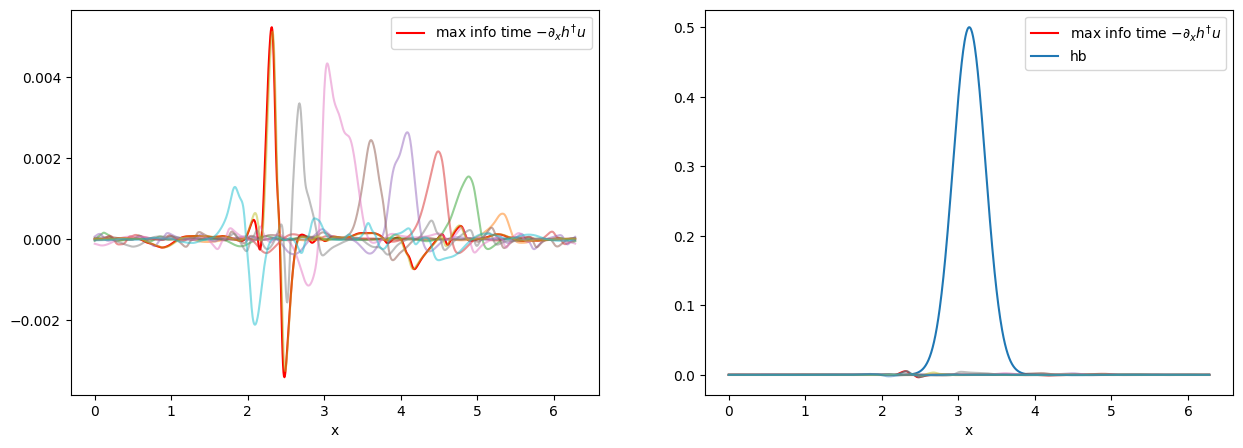

In [86]:
f,axs = plt.subplots(ncols= 2 , figsize = (15,5))


axs[0].plot(xx, -hx_uus[argmaxh_ux] , color = 'red', label = 'max info time $-\partial_x h^{\dag}  u $')

for tt in range(0,20000,2000):
    axs[0].plot(xx, -hx_uus[tt] , alpha = 0.5 )
    axs[0].set_xlabel('x')
axs[0].legend()

axs[1].plot(xx, -hx_uus[argmaxh_ux] , color = 'red', label = 'max info time $-\partial_x h^{\dag}  u $')
axs[1].plot(xx , hb, label = 'hb')

for tt in range(0,20000,2000):
    axs[1].plot(xx, -hx_uus[tt] , alpha = 0.5 )
    axs[1].set_xlabel('x')
axs[1].legend()

plots de optimzacion


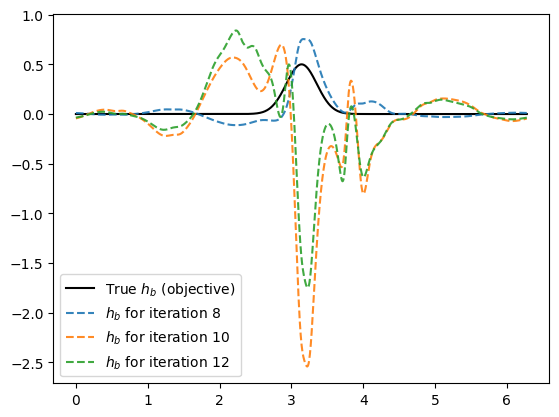

In [96]:
hbs =  np.load(f'{bpm.hb_path}/hb_memmap.npy', mmap_mode='r')  # all t hx_uu
true_hb = np.load(f'{bpm.data_path}/hb.npy')

plt.plot(xx, true_hb, label = 'True $h_b$ (objective)', color = 'black')
for iit in [8,10,12]:
    plt.plot(xx, hbs[iit], label = f'$h_b$ for iteration {iit}', alpha = .9 , linestyle = '--')
plt.legend()
